# Analyse Exploratoire des Données (EDA) pour les Images Pulmonaires

Ce notebook a pour but de réaliser une analyse exploratoire des données (EDA) sur un ensemble d'images pulmonaires classées en quatre typologies : COVID, Lung_Opacity, Normal et Viral Pneumonia. L'objectif est de comprendre la distribution des données, vérifier la qualité des images, et identifier des patterns potentiels avant de passer à l'étape de modélisation en machine learning.

## Chargement et Préparation des Données

Dans cette section, nous allons charger les métadonnées des images depuis des fichiers CSV, ajouter des colonnes pour identifier les typologies, et combiner les données en un seul DataFrame pour une analyse globale.

  FILE NAME FORMAT     SIZE  \
0   COVID-1    PNG  256*256   
1   COVID-2    PNG  256*256   
2   COVID-3    PNG  256*256   
3   COVID-4    PNG  256*256   
4   COVID-5    PNG  256*256   

                                                 URL TIPOLOGIA  
0  https://sirm.org/category/senza-categoria/covi...     COVID  
1  https://sirm.org/category/senza-categoria/covi...     COVID  
2  https://sirm.org/category/senza-categoria/covi...     COVID  
3  https://sirm.org/category/senza-categoria/covi...     COVID  
4  https://sirm.org/category/senza-categoria/covi...     COVID  
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL', 'TIPOLOGIA'], dtype='object')
       FILE NAME FORMAT     SIZE  \
count      21165  21165    21165   
unique     21165      1        1   
top      COVID-1    PNG  256*256   
freq           1  21165    21165   

                                                      URL TIPOLOGIA  
count                                               21165     21165  
unique                     

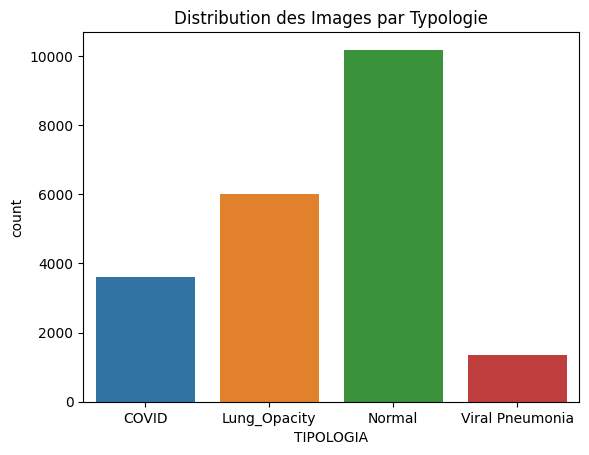

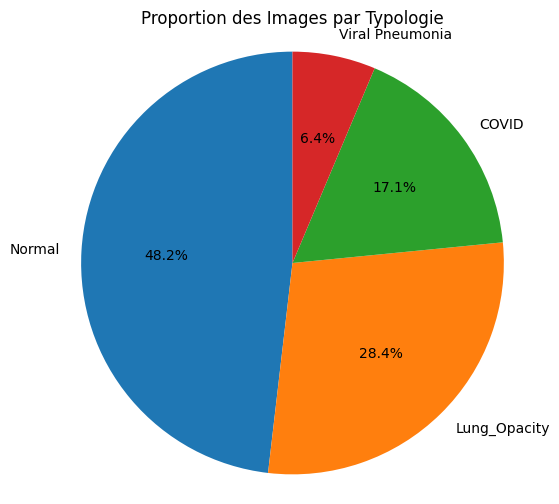

256*256    21165
Name: SIZE, dtype: int64


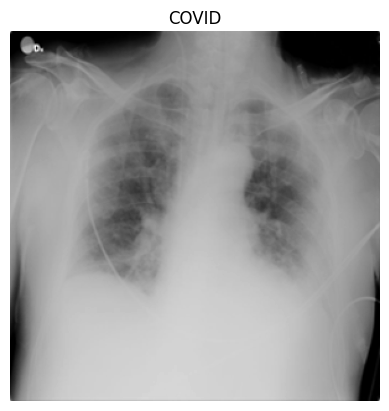

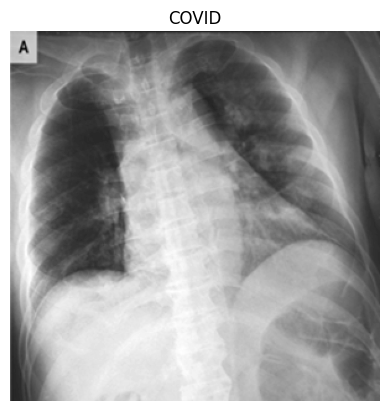

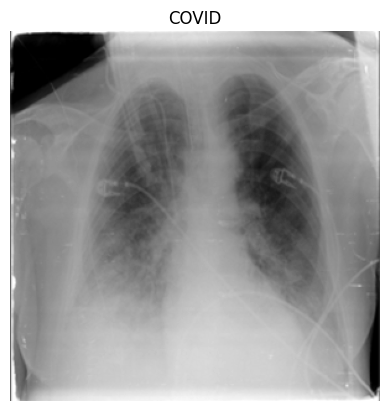

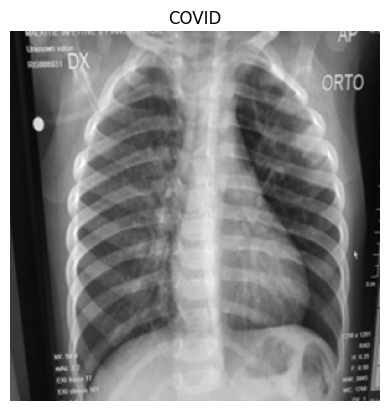

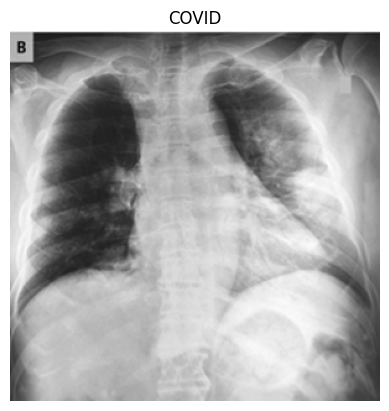

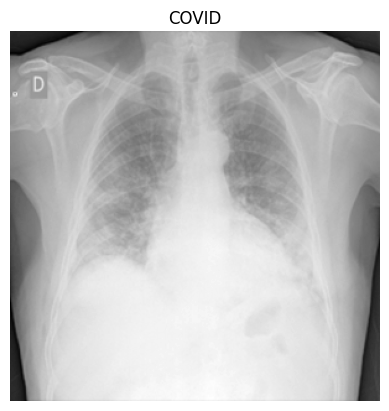

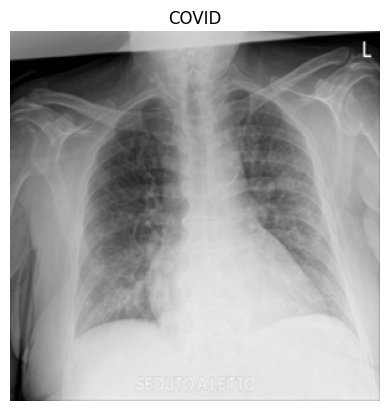

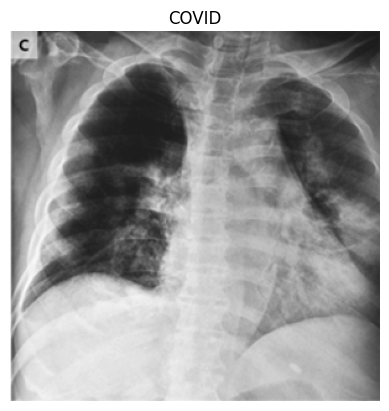

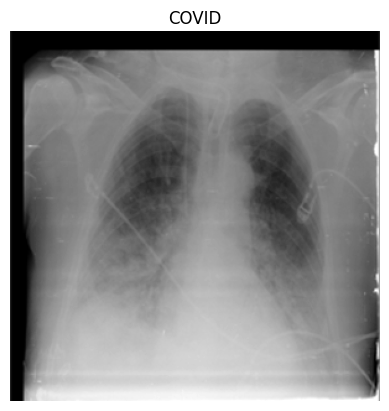

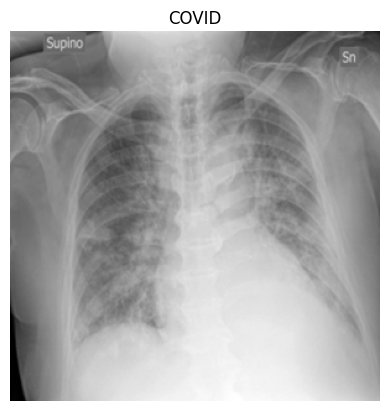

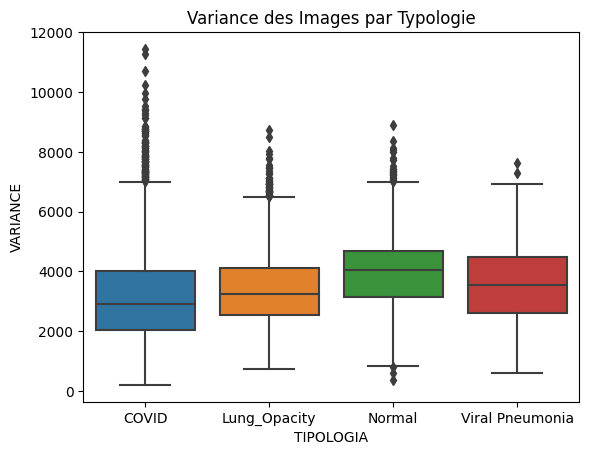

=== Statistiques de la variance par typologie (images valides uniquement) ===
                        mean          std       median  count
TIPOLOGIA                                                    
COVID            3206.175555  1680.907333  2920.897815   3616
Lung_Opacity     3379.698600  1134.047215  3241.053406   5989
Normal           3878.794366  1111.602287  4034.628885  10183
Viral Pneumonia  3557.267374  1231.523206  3541.812399   1331


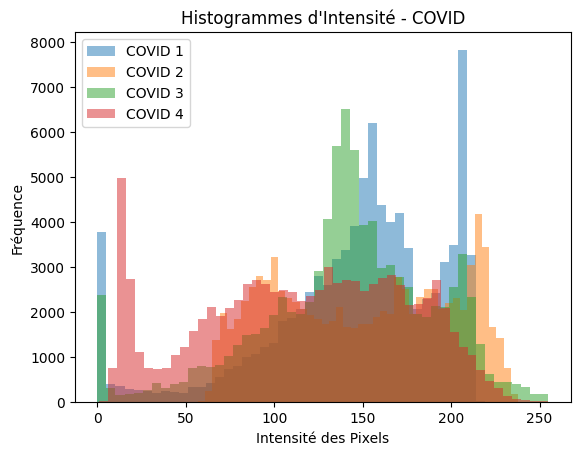

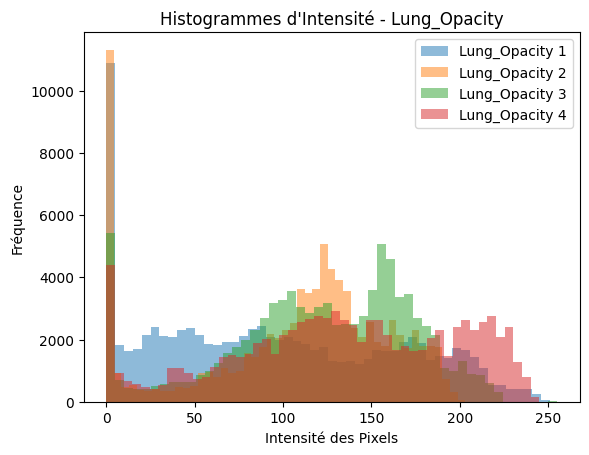

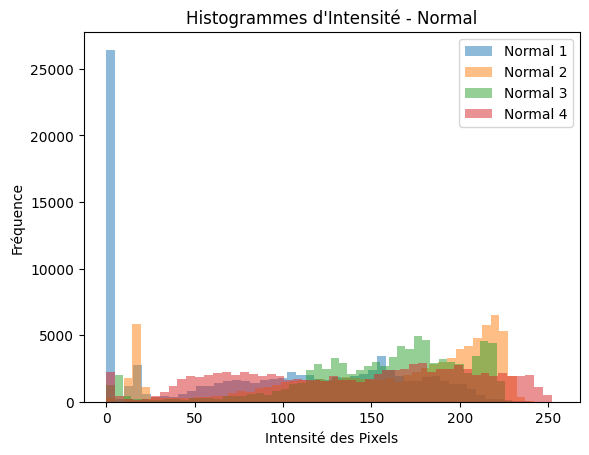

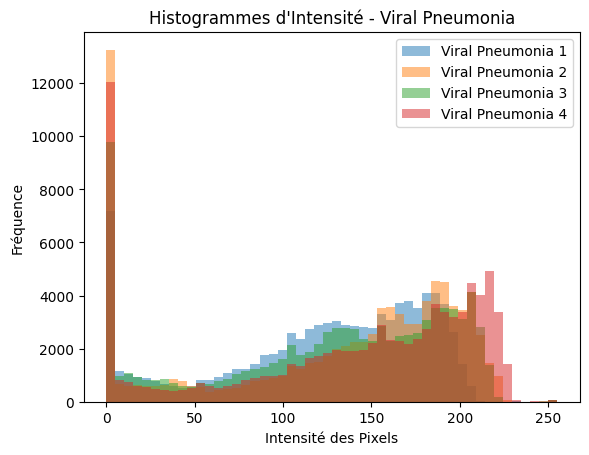

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np

# Chargement des métadonnées
df1 = pd.read_csv('COVID.metadata.csv', header=0, sep=';')
df2 = pd.read_csv('Lung_Opacity.metadata.csv', header=0, sep=';')
df3 = pd.read_csv('Normal.metadata.csv', header=0, sep=';')
df4 = pd.read_csv('Viral Pneumonia.metadata.csv', header=0, sep=';')

# Ajout du champ TIPOLOGIA
df1['TIPOLOGIA'] = 'COVID'
df2['TIPOLOGIA'] = 'Lung_Opacity'
df3['TIPOLOGIA'] = 'Normal'
df4['TIPOLOGIA'] = 'Viral Pneumonia'

# Fusion des jeux de données
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Aperçu
print(df.head())
print(df.columns)
print(df.describe())
print(df.isnull().sum())

# Graphique en barres : distribution des étiquettes
sns.countplot(data=df, x='TIPOLOGIA')
plt.title('Distribution des Images par Typologie')
plt.show()

# Tarte : proportion des images
tipologie_counts = df['TIPOLOGIA'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(tipologie_counts, labels=tipologie_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proportion des Images par Typologie')
plt.axis('equal')
plt.show()

# Vérification des tailles d'image
if 'SIZE' in df.columns:
    print(df['SIZE'].value_counts())
else:
    print("La colonne 'SIZE' n'existe pas dans le DataFrame.")

# Visualisation de quelques images (avec contrôle d'existence)
if 'FILE NAME' in df.columns and 'TIPOLOGIA' in df.columns:
    count = 0
    i = 0
    while count < 10 and i < len(df):
        img_path = os.path.join('images_v2', df['TIPOLOGIA'].iloc[i], df['FILE NAME'].iloc[i] + '.png')
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('L')
            plt.imshow(img, cmap='gray')
            plt.title(df['TIPOLOGIA'].iloc[i])
            plt.axis('off')
            plt.show()
            count += 1
        i += 1
else:
    print("Les colonnes 'FILE NAME' ou 'TIPOLOGIA' sont manquantes.")

# Calcul de la variance par image (si elle existe)
variances = []
chemins_valides = []

for i in range(len(df)):
    img_path = os.path.join('images_v2', df['TIPOLOGIA'].iloc[i], df['FILE NAME'].iloc[i] + '.png')
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            variances.append(np.var(img_array))
            chemins_valides.append(True)
        except:
            variances.append(np.nan)
            chemins_valides.append(False)
    else:
        variances.append(np.nan)
        chemins_valides.append(False)

df['VARIANCE'] = variances
df['EXISTE'] = chemins_valides

# Boxplot des variances (images valides uniquement)
sns.boxplot(data=df[df['EXISTE']], x='TIPOLOGIA', y='VARIANCE')
plt.title('Variance des Images par Typologie')
plt.show()

# Moyennes et écarts-types de variance par typologie
stats_var = df[df['EXISTE']].groupby('TIPOLOGIA')['VARIANCE'].agg(['mean', 'std', 'median', 'count'])
print("=== Statistiques de la variance par typologie (images valides uniquement) ===")
print(stats_var)

# Histogrammes d'intensité (seulement si les images existent)
for typ in df['TIPOLOGIA'].unique():
    subset = df[(df['TIPOLOGIA'] == typ) & (df['EXISTE'])]
    plt.figure()
    count = 0
    i = 0
    while count < 4 and i < len(subset):
        row = subset.iloc[i]
        img_path = os.path.join('images_v2', row['TIPOLOGIA'], row['FILE NAME'] + '.png')
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            plt.hist(img_array.flatten(), bins=50, alpha=0.5, label=f'{typ} {count+1}')
            count += 1
        i += 1
    plt.title(f'Histogrammes d\'Intensité - {typ}')
    plt.xlabel('Intensité des Pixels')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.show()


  FILE NAME FORMAT     SIZE  \
0   COVID-1    PNG  256*256   
1   COVID-2    PNG  256*256   
2   COVID-3    PNG  256*256   
3   COVID-4    PNG  256*256   
4   COVID-5    PNG  256*256   

                                                 URL TIPOLOGIA  
0  https://sirm.org/category/senza-categoria/covi...     COVID  
1  https://sirm.org/category/senza-categoria/covi...     COVID  
2  https://sirm.org/category/senza-categoria/covi...     COVID  
3  https://sirm.org/category/senza-categoria/covi...     COVID  
4  https://sirm.org/category/senza-categoria/covi...     COVID  
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL', 'TIPOLOGIA'], dtype='object')
       FILE NAME FORMAT     SIZE  \
count      21165  21165    21165   
unique     21165      1        1   
top      COVID-1    PNG  256*256   
freq           1  21165    21165   

                                                      URL TIPOLOGIA  
count                                               21165     21165  
unique                     

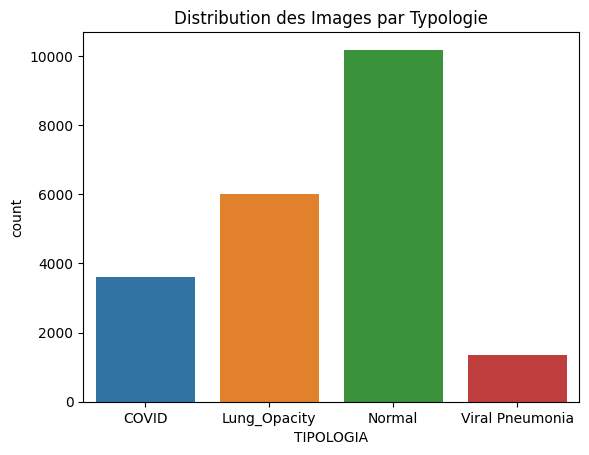

256*256    21165
Name: SIZE, dtype: int64


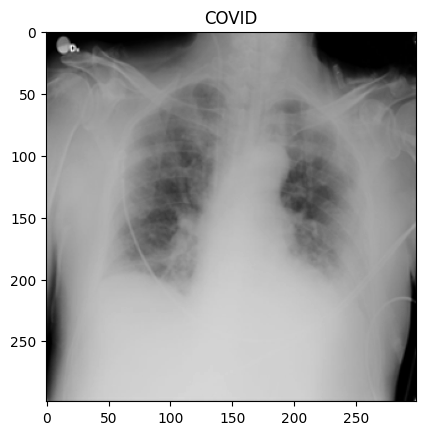

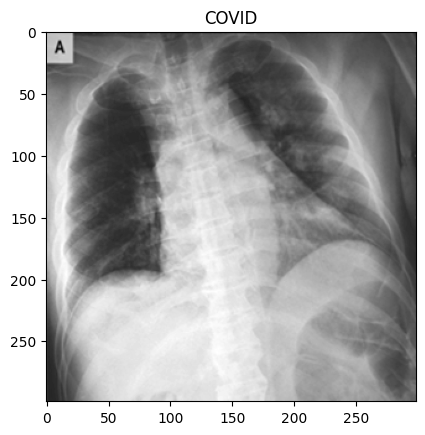

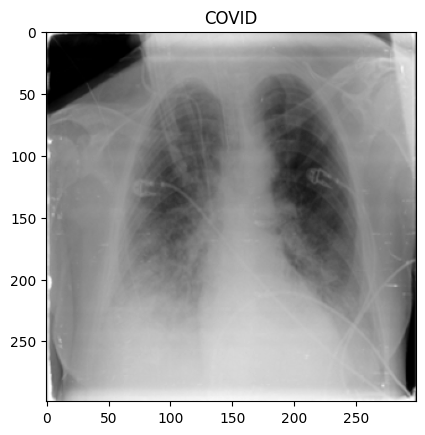

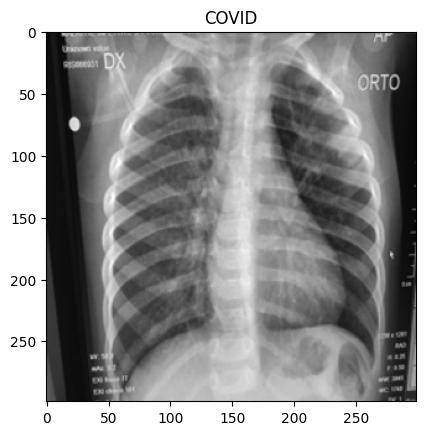

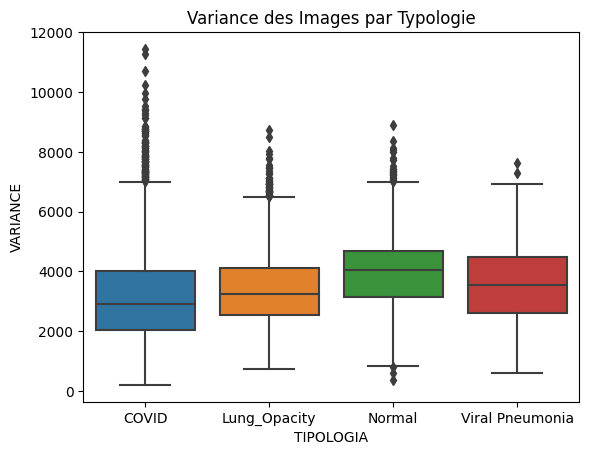

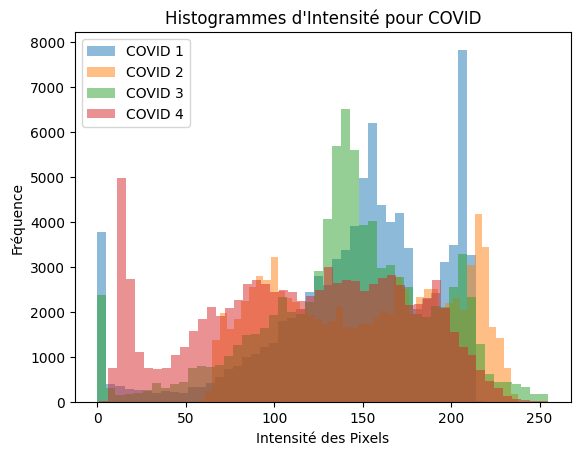

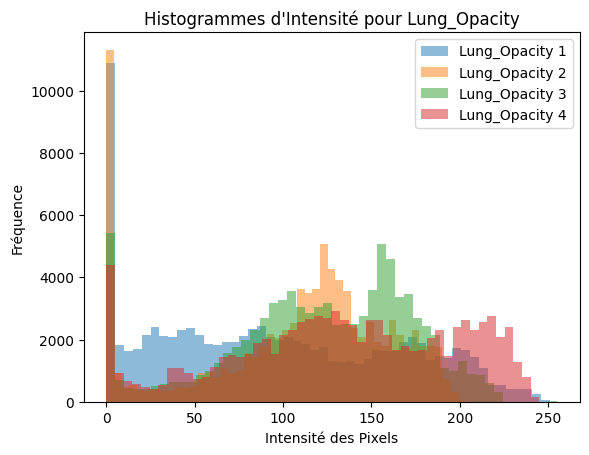

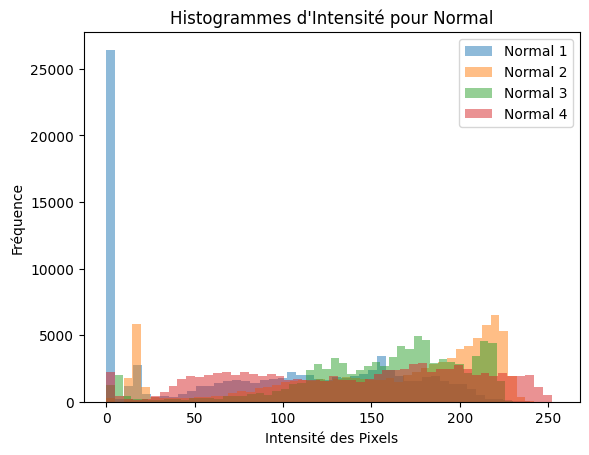

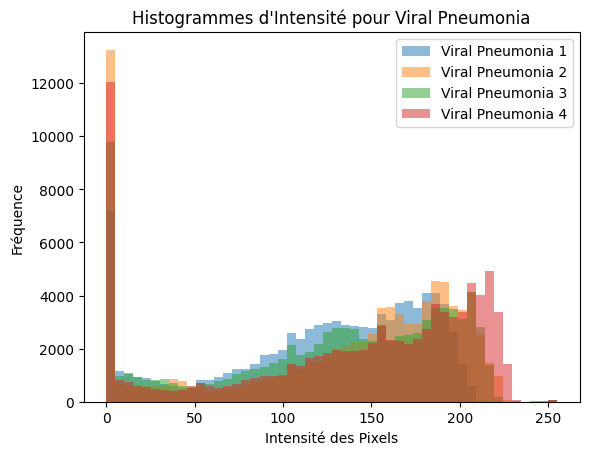

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np

# Charger les données depuis les fichiers CSV avec la première ligne comme en-tête et ; comme séparateur
df1 = pd.read_csv('COVID.metadata.csv', header=0, sep=';')
df2 = pd.read_csv('Lung_Opacity.metadata.csv', header=0, sep=';')
df3 = pd.read_csv('Normal.metadata.csv', header=0, sep=';')
df4 = pd.read_csv('Viral Pneumonia.metadata.csv', header=0, sep=';')

# Ajouter la colonne 'TIPOLOGIA' à chaque DataFrame
df1['TIPOLOGIA'] = 'COVID'
df2['TIPOLOGIA'] = 'Lung_Opacity'
df3['TIPOLOGIA'] = 'Normal'
df4['TIPOLOGIA'] = 'Viral Pneumonia'

# Combiner tous les DataFrames en un seul
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Afficher les premières lignes du DataFrame
print(df.head())

# Imprimer les noms des colonnes
print(df.columns)

# Résumé statistique
print(df.describe())

# Vérifier les valeurs nulles
print(df.isnull().sum())

# Distribution des images par typologie
sns.countplot(data=df, x='TIPOLOGIA')
plt.title('Distribution des Images par Typologie')
plt.show()

# Vérifier les tailles des images
if 'SIZE' in df.columns:
    print(df['SIZE'].value_counts())
else:
    print("La colonne 'SIZE' n'existe pas dans le DataFrame.")

# Visualiser quelques images
if 'FILE NAME' in df.columns and 'TIPOLOGIA' in df.columns:
    for i in range(4):
        img_path = os.path.join('images_v2', df['TIPOLOGIA'].iloc[i], df['FILE NAME'].iloc[i] + '.png')
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('L')  # Convertir en niveaux de gris
            plt.imshow(img, cmap='gray')
            plt.title(df['TIPOLOGIA'].iloc[i])
            plt.show()
        else:
            print(f"Image non trouvée: {img_path}")
else:
    print("Les colonnes 'FILE NAME' ou 'TIPOLOGIA' n'existent pas dans le DataFrame.")

# Analyse de la variance des images
variances = []
for i in range(len(df)):
    img_path = os.path.join('images_v2', df['TIPOLOGIA'].iloc[i], df['FILE NAME'].iloc[i] + '.png')
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('L')
        img_array = np.array(img)
        variances.append(np.var(img_array))
    else:
        variances.append(None)

df['VARIANCE'] = variances
sns.boxplot(data=df, x='TIPOLOGIA', y='VARIANCE')
plt.title('Variance des Images par Typologie')
plt.show()

# Visualisation des histogrammes d'intensité
for tipologia in df['TIPOLOGIA'].unique():
    subset = df[df['TIPOLOGIA'] == tipologia]
    plt.figure()
    for i in range(4):
        img_path = os.path.join('images_v2', subset['TIPOLOGIA'].iloc[i], subset['FILE NAME'].iloc[i] + '.png')
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            plt.hist(img_array.flatten(), bins=50, alpha=0.5, label=f'{tipologia} {i+1}')
        else:
            print(f"Image non trouvée: {img_path}")
    plt.title(f'Histogrammes d\'Intensité pour {tipologia}')
    plt.xlabel('Intensité des Pixels')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.show()


Experimentation avec modeles SVM et Random Forest

=== RANDOM FOREST ===
=== RAPPORT DE CLASSIFICATION (Random Forest) ===
                 precision    recall  f1-score   support

          COVID       0.89      0.79      0.84       723
         Normal       0.91      0.97      0.94      2037
Viral Pneumonia       0.93      0.82      0.87       266

       accuracy                           0.91      3026
      macro avg       0.91      0.86      0.88      3026
   weighted avg       0.91      0.91      0.91      3026



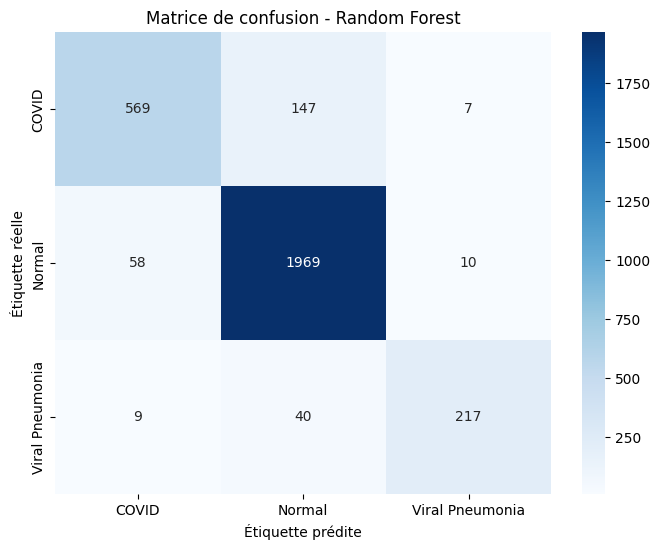

AUC macro (RF): 0.9813
AUC pondéré (RF): 0.9757

=== SVM ===


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v3"  # Remplacez par le chemin réel de votre dataset
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Chargement des chemins des images et des étiquettes
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement et traitement des images
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Attention: Impossible de charger l'image {image_path}: {e}")

# Conversion en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # S'assurer que les tailles correspondent

# Aplatissement des images pour les modèles classiques
n_samples = all_images.shape[0]
flat_images = all_images.reshape(n_samples, -1)

# Division des données en entraînement et validation
x_train, x_val, y_train, y_val = train_test_split(
    flat_images, labels, test_size=0.2, stratify=labels, random_state=42
)

# Entraînement avec Random Forest
print("=== RANDOM FOREST ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_val)
y_pred_proba_rf = rf_model.predict_proba(x_val)

# Rapport de classification
print("=== RAPPORT DE CLASSIFICATION (Random Forest) ===")
print(classification_report(y_val, y_pred_rf, target_names=label_to_index.keys(), digits=2))

# Matrice de confusion
cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.title("Matrice de confusion - Random Forest")
plt.show()

# AUC
y_val_bin = label_binarize(y_val, classes=list(range(len(label_to_index))))
auc_macro_rf = roc_auc_score(y_val_bin, y_pred_proba_rf, average="macro", multi_class="ovr")
auc_weighted_rf = roc_auc_score(y_val_bin, y_pred_proba_rf, average="weighted", multi_class="ovr")
print(f"AUC macro (RF): {auc_macro_rf:.4f}")
print(f"AUC pondéré (RF): {auc_weighted_rf:.4f}")


# Entraînement avec SVM (avec probabilité)
print("\n=== SVM ===")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_val)
y_pred_proba_svm = svm_model.predict_proba(x_val)

# Rapport de classification
print("=== RAPPORT DE CLASSIFICATION (SVM) ===")
print(classification_report(y_val, y_pred_svm, target_names=label_to_index.keys(), digits=2))

# Matrice de confusion
cm_svm = confusion_matrix(y_val, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.title("Matrice de confusion - SVM")
plt.show()

# AUC
auc_macro_svm = roc_auc_score(y_val_bin, y_pred_proba_svm, average="macro", multi_class="ovr")
auc_weighted_svm = roc_auc_score(y_val_bin, y_pred_proba_svm, average="weighted", multi_class="ovr")
print(f"AUC macro (SVM): {auc_macro_svm:.4f}")
print(f"AUC pondéré (SVM): {auc_weighted_svm:.4f}")


en %

=== RANDOM FOREST ===
=== RAPPORT DE CLASSIFICATION (Random Forest) ===
                 precision    recall  f1-score   support

          COVID       0.89      0.79      0.84       723
         Normal       0.91      0.97      0.94      2037
Viral Pneumonia       0.93      0.82      0.87       266

       accuracy                           0.91      3026
      macro avg       0.91      0.86      0.88      3026
   weighted avg       0.91      0.91      0.91      3026



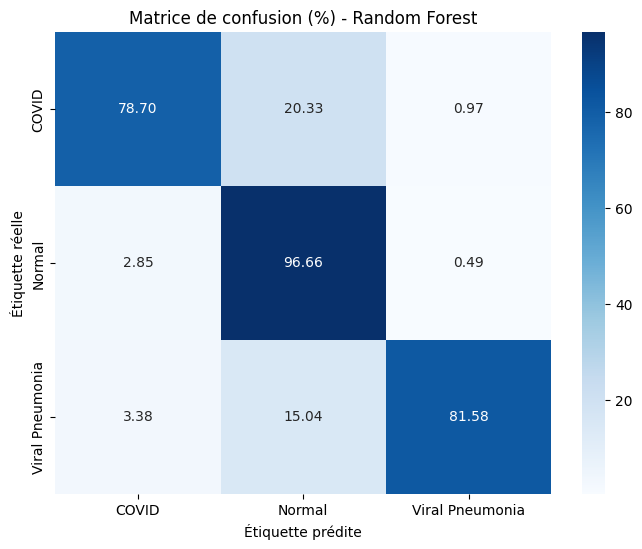

AUC macro (RF): 0.9813
AUC pondéré (RF): 0.9757


In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration de base
DATASET_DIR = "images_v3"  # Remplacez par le chemin réel de votre dataset
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Chargement des chemins des images et des étiquettes
image_paths = []
labels = []

for class_name in os.listdir(DATASET_DIR):
    class_path = os.path.join(DATASET_DIR, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path):
                image_paths.append(image_path)
                labels.append(class_name)

# Conversion des étiquettes en indices numériques
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = np.array([label_to_index[label] for label in labels])

# Chargement et traitement des images
all_images = []
for image_path in image_paths:
    try:
        image = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = tf.keras.utils.img_to_array(image) / 255.0  # Normalisation
        all_images.append(image)
    except Exception as e:
        print(f"Attention: Impossible de charger l'image {image_path}: {e}")

# Conversion en tableaux NumPy
all_images = np.array(all_images)
labels = np.array(labels[:len(all_images)])  # S'assurer que les tailles correspondent

# Aplatissement des images pour les modèles classiques
n_samples = all_images.shape[0]
flat_images = all_images.reshape(n_samples, -1)

# Division des données en entraînement et validation
x_train, x_val, y_train, y_val = train_test_split(
    flat_images, labels, test_size=0.2, stratify=labels, random_state=42
)

# === RANDOM FOREST ===
print("=== RANDOM FOREST ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_val)
y_pred_proba_rf = rf_model.predict_proba(x_val)

# Rapport de classification
print("=== RAPPORT DE CLASSIFICATION (Random Forest) ===")
print(classification_report(y_val, y_pred_rf, target_names=label_to_index.keys(), digits=2))

# Matrice de confusion en pourcentage
cm_rf = confusion_matrix(y_val, y_pred_rf)
cm_rf_percent = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_percent, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.title("Matrice de confusion (%) - Random Forest")
plt.show()

# AUC
y_val_bin = label_binarize(y_val, classes=list(range(len(label_to_index))))
auc_macro_rf = roc_auc_score(y_val_bin, y_pred_proba_rf, average="macro", multi_class="ovr")
auc_weighted_rf = roc_auc_score(y_val_bin, y_pred_proba_rf, average="weighted", multi_class="ovr")
print(f"AUC macro (RF): {auc_macro_rf:.4f}")
print(f"AUC pondéré (RF): {auc_weighted_rf:.4f}")





svm


=== SVM ===
=== RAPPORT DE CLASSIFICATION (SVM) ===
                 precision    recall  f1-score   support

          COVID       0.87      0.78      0.82       723
         Normal       0.92      0.96      0.94      2037
Viral Pneumonia       0.95      0.89      0.92       266

       accuracy                           0.91      3026
      macro avg       0.91      0.88      0.89      3026
   weighted avg       0.91      0.91      0.91      3026



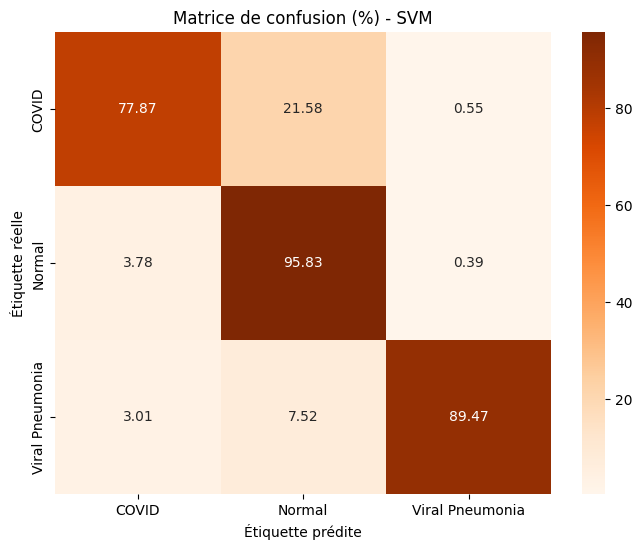

AUC macro (SVM): 0.9809
AUC pondéré (SVM): 0.9750


In [2]:
# === SVM ===
print("\n=== SVM ===")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_val)
y_pred_proba_svm = svm_model.predict_proba(x_val)

# Rapport de classification
print("=== RAPPORT DE CLASSIFICATION (SVM) ===")
print(classification_report(y_val, y_pred_svm, target_names=label_to_index.keys(), digits=2))

# Matrice de confusion en pourcentage
cm_svm = confusion_matrix(y_val, y_pred_svm)
cm_svm_percent = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis] * 100
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_percent, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=label_to_index.keys(), yticklabels=label_to_index.keys())
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.title("Matrice de confusion (%) - SVM")
plt.show()

# AUC
auc_macro_svm = roc_auc_score(y_val_bin, y_pred_proba_svm, average="macro", multi_class="ovr")
auc_weighted_svm = roc_auc_score(y_val_bin, y_pred_proba_svm, average="weighted", multi_class="ovr")
print(f"AUC macro (SVM): {auc_macro_svm:.4f}")
print(f"AUC pondéré (SVM): {auc_weighted_svm:.4f}")